# Cosmo case

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats
from scipy import integrate
from scipy.optimize import minimize
import tqdm
from IPython.display import display, Math
import corner
import MH_MCMC

plt.rcParams['figure.dpi'] = 200

## function we will use for the cosmology project

In [2]:
# defines the general form of the integrand to be used throughout
def integrand(z, h, omega_r, omega_m, omega_l, omega_k):
    # speed of light given in units of km/s
    # Hubble constant given in units of km/s/Mpc
    c = 2.998e5
    H_0 = h*100
    d_H = c/H_0
    integrand = d_H/np.sqrt(omega_r*(1.0 + z)**(4.0) + omega_m*(1.0 + z)**(3.0)\
                            + omega_l + omega_k*(1.0 + z)**(2.0)) # Friedmann equation
    return integrand

# comoving distance as a function of redshift, Hubble constant, matter density, and spatial curvature
def d_C(z, h, omega_m, omega_k):
    # Hubble constant given in units of km/s/Mpc
    # comoving distance returned in units of Mpc
    omega_r = 4.18e-5*(h)**(-2.0)
    omega_l = 1.0 - omega_m - omega_k
    d_C = integrate.quad(integrand, 0.0, z, args=(h, omega_r, omega_m, omega_l, omega_k))[0]
    return d_C

# comoving angular diameter distance as a function of redshift, Hubble constant, matter density, and spatial curvature
def d_M(z, h, omega_m, omega_k):
    # speed of light given in units of km/s
    # Hubble constant given in units of km/s/Mpc
    # angular diameter distance returned in units of Mpc
    c = 2.998e5
    H_0 = h*100
    d_H = c/H_0
    if omega_k < 0.0: 
        d_M = (d_H/np.sqrt(np.abs(omega_k)))*np.sin(np.sqrt(np.abs(omega_k))*(d_C(z, h, omega_m, omega_k)/d_H))
    if omega_k == 0.0:
        d_M = d_C(z, h, omega_m, omega_k)
    if omega_k > 0.0:
        d_M = (d_H/np.sqrt(np.abs(omega_k)))*np.sinh(np.sqrt(np.abs(omega_k))*(d_C(z, h, omega_m, omega_k)/d_H))
    return d_M

# angular diameter distance as a function of redshift, Hubble constant, matter density, and spatial curvature
def d_A(z, h, omega_m, omega_k):
    # Hubble constant given in units of km/s/Mpc
    # angular diameter distance returned in units of Mpc
    d_A = d_M(z, h, omega_m, omega_k)/(1.0 + z)
    return d_A

# ratio of sound horizon to comoving angular diameter distance as a function of redshift, Hubble constant, matter density, and spatial curvature
def ratio(z, h, omega_m, omega_k):
    # sound horizon given in units of Mpc
    # angular diameter distance given in units of Mpc
    # sound horizon coming from Planck Collaboration+2018
    r_D = 147.09
    return r_D/d_M(z, h, omega_m, omega_k)


In [3]:
# model definition:
def modelFunction(x, w):
    h, omega_m, omega_k = w
    model = np.copy(x)
    for i, x_i in enumerate(x):
        model[i] = ratio(x_i, h, omega_m, omega_k)
    return model

In [4]:
# likelyhood function
def logLikelihood(w, x, y, yerr):
    h, omega_m, omega_k = w
    model = modelFunction(x, w)
    sigma2 = yerr ** 2.
    return -0.5 * np.sum((y - model) ** 2. / sigma2 + np.log(sigma2))

In [5]:
# Prior distribution: only give a limitation range here
def logPrior(w,wrange):
    #m, b, log_f = w
    for i in range(len(w)):
        if (w[i] < wRange[i,0]) or (w[i] > wRange[i,1]):
            return -np.inf
    return 0.0

In [6]:
# Prob = Prior * Likelyhood
def log_probability(w, wrange,x, y, yerr):
    lp = logPrior(w,wrange)
    ll = logLikelihood(w, x, y, yerr)
    if not np.isfinite(lp) or np.isnan(ll):
        return -np.inf
    else:
        return lp + ll

In [7]:
# how to walk in parameter space for each step
def propose(w,sigma):
    nParam = len(w)
    wNew = np.zeros_like(w, dtype=np.float64)
    wNew[:] = w

    # Which one should we change? only one parameter changes in each step
    i = int(np.random.rand()*nParam)
    wNew[i] += stats.norm(0, sigma).rvs()

    return wNew

In [8]:
# main function for MCMC
def MCMC(Nwalkers, Nsteps, data, wrange, w0,sigma):
    total_chain = np.zeros((Nwalkers,Nsteps,4))
    for walker in tqdm.tqdm_notebook(range(Nwalkers)): 
        x, y, yerr = data

        # start off at some random w drawn from our prior distribution
        w = w0[walker]
        logp, logl = logPrior(w,wrange), logLikelihood(w,x, y, yerr)

        nParam = w.shape[0] # the value of w plus its likelihood
        chain = np.zeros((Nsteps, nParam + 1))

        # count the number of successful proposals
        ngood = 0

        for i in tqdm.tqdm_notebook(range(Nsteps)):
            wNew = propose(w,sigma)
            logpNew = logPrior(wNew,wrange)


            # Only evaluate the likelihood if prior prob isn't zero
            loglNew = -np.Inf
            if logpNew != -np.Inf:
                loglNew = logLikelihood(wNew,x, y, yerr)
                
            # only evaluate total probability if both prior and likelyhood are valid    
            if loglNew == -np.Inf or np.isnan(loglNew):
                logRatio = -np.Inf
            else:
                # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w)p(w) )
                logRatio = (logpNew + loglNew) - (logp + logl)
            logRatio = min(0.0, logRatio)

            # Acceptance/rejection
            if np.random.rand() <= np.exp(logRatio):
                w = wNew
                logp = logpNew
                logl = loglNew
                ngood += 1

            chain[i, :-1] = w
            chain[i, -1] = logl
            total_chain[walker,i,:] = chain[i,:]
    return total_chain, ngood/Nsteps

In [9]:
# autocorrelated function -> determine every N steps to pick one step
def autocorrelate(x,lags):
    n=len(x)
    # pad 0s to 2n-1
    size=2*n-1
    
    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp, size)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]


def auto(chain, nlag, labs):
    nParam = chain.shape[1]-1
    lags = np.arange(nlag)
    fig, ax = plt.subplots()
    for i in range(nParam):
        result = autocorrelate(chain[:,i],lags)
        ax.plot(result, label=labs[i])
    ax.legend()
    ax.set_xlabel('lag k [steps]')
    ax.set_ylabel('P(k)')
    plt.tight_layout();

## data

In [10]:
# data from Alam+2017 + Ata+2018 + Bautista+2017 + Planck Collaboration+2018
# redshift
data_x = np.array([0.38, 0.51, 0.61, 1.52, 2.33, 1059.94])
# ratio of sound horizon to comoving angular diameter distance
data_y = np.array([0.0973518, 0.0747496, 0.0647306, 0.0328036, 0.0264760, 0.0106027])
# error in ratio of sound horizon to comoving angular diameter distance
data_z = np.array([0.0019881, 0.0013990, 0.0012475, 0.0003059, 0.0014931, 0.0000031])

## 1 walker with $2 \times 10^{5}$ steps

In [11]:
#I did not use the Planck values for initial state because it cannot get a good reuslt

Nwalkers = 1
initial_state = np.array([+0.6, +0.3, +0.1]) 
initial_state_array = initial_state + 0*np.random.randn(Nwalkers, 3)

In [12]:
# the number of walkers
N = 2*10**5

# our data
data = [data_x,data_y,data_z]

# Ranges in parameter values:
wRange = np.array([[0.0,1.0],[0.0,1.0], [-1.0,1.0]])

#the sigma for a normal distribution of p(wnew/w)
sigma=np.array([0.001])

# run MCMC
for sigma_try in sigma:
    chain, goodFrac = MCMC\
    (Nwalkers = Nwalkers, Nsteps = N, data = data,wrange = wRange,w0 = initial_state_array,sigma = sigma_try)

    print(f"\n\nAcdeptance ratio: {goodFrac}")





Acdeptance ratio: 0.287665


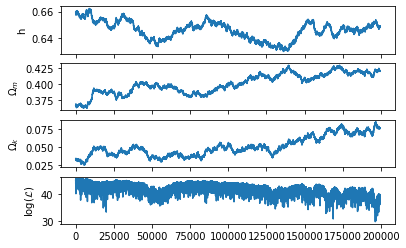

In [13]:
# Have a look on the MC chains 
walker=0
burn=500
end = -1

h = chain[walker,burn:end,0]
omega_m = chain[walker,burn:end,1]
omega_k = chain[walker,burn:end,2]
ll = chain[walker,burn:end,3]



fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(h)
ax[0].set_ylabel(r'h')

ax[1].plot(omega_m)
ax[1].set_ylabel(r'$\Omega_{m}$')

ax[2].plot(omega_k)
ax[2].set_ylabel(r'$\Omega_{k}$')


ax[3].plot(ll)
ax[3].set_ylabel(r'$\log(\mathcal{L})$');

#samples = chain[burn:,:]

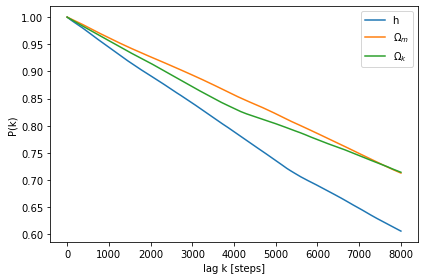

In [14]:
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

auto(chain[0,burn:end,:], nlag=8000, labs=labels)

samples = chain[0,burn:end,:]

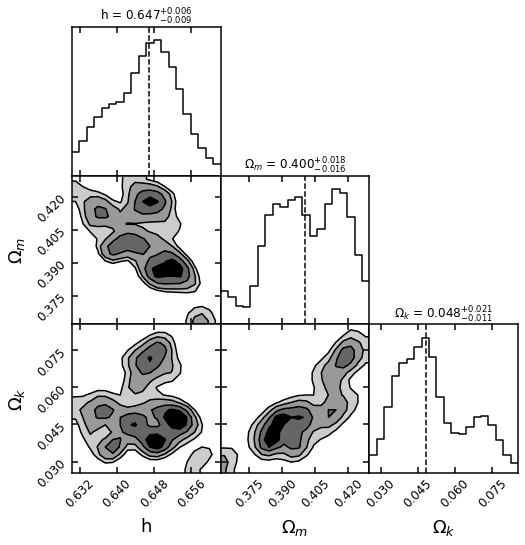

In [15]:
# show corner
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

fig = corner.corner(\
    samples[:,:-1],\
    truths=initial_state,\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


## 64 walkes with $2 \times 10^{4}$ steps

In [16]:
# initial state from Planck Collaboration+2018, [h, omega_m, omega_k]

Nwalkers = 64
initial_state = np.array([+0.674, +0.315, +0.001])
initial_state_array = initial_state + 1e-3*np.random.randn(Nwalkers, 3)

In [17]:
# the number of walkers
N = 2*10**4

# our data
data = [data_x,data_y,data_z]

# Ranges in parameter values:
wRange = np.array([[0.0,1.0],[0.0,1.0], [-1.0,1.0]])

# run MCMC
chain, goodFrac = MCMC(Nwalkers = Nwalkers, Nsteps = N, data = data,wrange = wRange,w0 = initial_state_array,sigma = 0.001)

print(f"\n\nAcdeptance ratio: {goodFrac}")





Acdeptance ratio: 0.26095


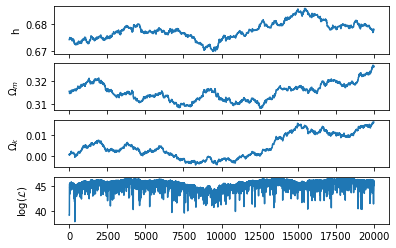

In [18]:
# Have a look on the MC chains 
walker=2
burn=0
end = -1

h = chain[walker,burn:end,0]
omega_m = chain[walker,burn:end,1]
omega_k = chain[walker,burn:end,2]
ll = chain[walker,burn:end,3]



fig, ax = plt.subplots(4, 1, sharex=True)
ax[0].plot(h)
ax[0].set_ylabel(r'h')

ax[1].plot(omega_m)
ax[1].set_ylabel(r'$\Omega_{m}$')

ax[2].plot(omega_k)
ax[2].set_ylabel(r'$\Omega_{k}$')


ax[3].plot(ll)
ax[3].set_ylabel(r'$\log(\mathcal{L})$');

#samples = chain[burn:,:]

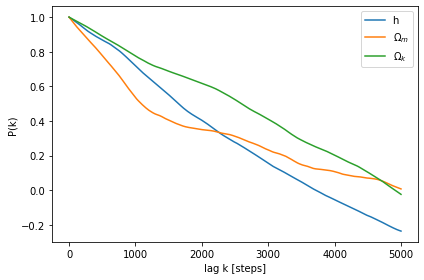

In [19]:
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

auto(chain[walker,burn:end,:], nlag=5000, labs=labels)

In [20]:
#combine all of chains of walkers: 
#burn is the first N steps which will be discarded
#thin is every how many steps choose one step to avoid co-corelated between adjacent steps
def flat_chain(chain,burn=100, thin=1500):
    walker = len(chain)
    Nsteps = len(chain[0])
    NParams = len(chain[0][0])
    print(walker,Nsteps,NParams)
    use_chain_point_all = []
    for i in range(walker):
        use_walker_chain = chain[i,burn:,:]
        use_len = len(use_walker_chain)
        index = 0
        while index < use_len:
            use_chain_point_all.append(use_walker_chain[index,:])
            index+=thin
    
    return np.array(use_chain_point_all)
        
        

In [21]:
final_chain = flat_chain(chain,burn=1000, thin=2000)
samples = final_chain

64 20000 4


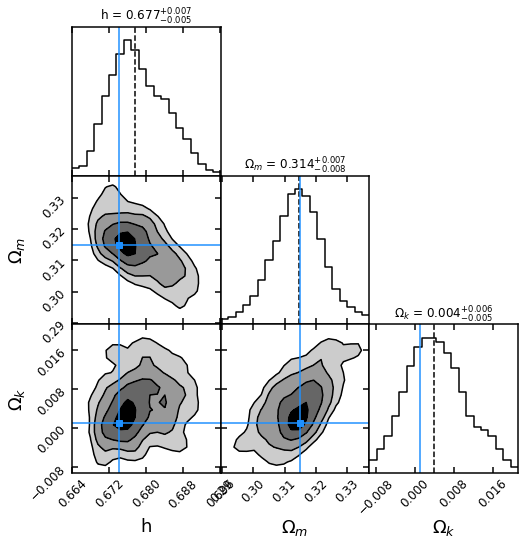

In [22]:
# show corner
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

fig = corner.corner(\
    samples[:,:-1],\
    truths=initial_state,\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


/Users/sunyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.082, 0.5, '${100*r_{D}/d_{M}}$')

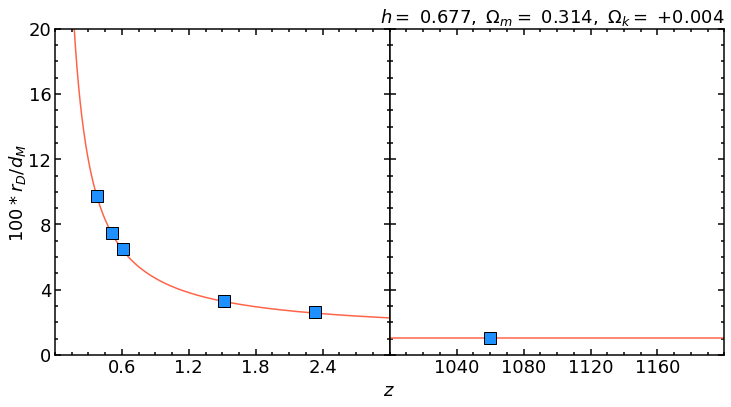

In [23]:
# loops through each value of redshift
z_array_1 = np.linspace(0.0, 3.0, 1001)
z_array_2 = np.linspace(1000.0, 1200.0, 1001)
ratio_array_1 = np.copy(z_array_1)
ratio_array_2 = np.copy(z_array_2)
best_fit_1 = np.median(samples[:, 0])
best_fit_2 = np.median(samples[:, 1])
best_fit_3 = np.median(samples[:, 2])
for i, z in enumerate(z_array_1):
    ratio_array_1[i] = ratio(z, best_fit_1, best_fit_2, best_fit_3)
for i, z in enumerate(z_array_2):
    ratio_array_2[i] = ratio(z, best_fit_1, best_fit_2, best_fit_3)
    
# plotting the distance measurement fit of running emcee
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey='row')

axs[0].tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=18)
axs[0].tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=18)
axs[0].set_xlim(0.0, 3.0)
axs[0].set_ylim(0.0, 20.0)
axs[0].set_xticks((0.6, 1.2, 1.8, 2.4))
axs[0].set_yticks((0.0, 4.0, 8.0, 12.0, 16.0, 20.0))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.15))
axs[0].yaxis.set_minor_locator(MultipleLocator(1.00))

axs[1].tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=18)
axs[1].tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=18)
axs[1].set_xlim(1000.0, 1200.0)
axs[1].set_ylim(0.0, 20.0)
axs[1].set_xticks((1040, 1080, 1120, 1160))
axs[1].set_yticks((0.0, 4.0, 8.0, 12.0, 16.0, 20.0))
axs[1].xaxis.set_minor_locator(MultipleLocator(10.0))
axs[1].yaxis.set_minor_locator(MultipleLocator(1.00))


axs[0].plot(z_array_1, 100*ratio_array_1, color='tomato')
axs[0].plot(data_x, 100*data_y, color='dodgerblue', markeredgecolor='k', marker='s', markersize=12, ls='')
axs[0].errorbar(data_x, 100*data_y, yerr=100*data_z, color='dodgerblue', fmt='none', ls='')

axs[1].plot(z_array_2, 100*ratio_array_2, color='tomato')
axs[1].plot(data_x, 100*data_y, color='dodgerblue', markeredgecolor='k', marker='s', markersize=12, ls='')
axs[1].errorbar(data_x, 100*data_y, yerr=100*data_z, color='dodgerblue', fmt='none', ls='')

l1 = r'${h = \,\,}$' + r'${:5.3f}$'.format(best_fit_1)
l2 = r'${,\ \Omega_{m} = \,\,}$' + r'${:5.3f}$'.format(best_fit_2)
l3 = r'${,\ \Omega_{k} = \,\,}$' + r'${:+5.3f}$'.format(best_fit_3)
string = l1 + l2 + l3
plt.title(string, loc='right', fontsize=18)


for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(1.5)
    axs[1].spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)
fig.text(0.512, 0.042, r'${z}$', fontsize=18, ha='center', va='center')
fig.text(0.082, 0.500, r'${100*r_{D}/d_{M}}$', fontsize=18, ha='center', va='center', rotation=90)

# Adaptive MCMC

only 1 walker

here for each step, all parameters move together, which is proposed from a multivariate normal distribution.

In [24]:
# model definition:
def modelFunction(x, w):
    h, omega_m, omega_k = w
    model = np.copy(x)
    for i, x_i in enumerate(x):
        model[i] = ratio(x_i, h, omega_m, omega_k)
    return model


def priorFunction(w, wrange):
    for i in range(len(w)):
        if w[i]<wrange[i,0] or w[i]>wrange[i,1]:
            return 0.0
    else:
        return 1.0

In [25]:
# data from Alam+2017 + Ata+2018 + Bautista+2017 + Planck Collaboration+2018
# redshift
data_x = np.array([0.38, 0.51, 0.61, 1.52, 2.33, 1059.94])
# ratio of sound horizon to comoving angular diameter distance
data_y = np.array([0.0973518, 0.0747496, 0.0647306, 0.0328036, 0.0264760, 0.0106027])
# error in ratio of sound horizon to comoving angular diameter distance
data_z = np.array([0.0019881, 0.0013990, 0.0012475, 0.0003059, 0.0014931, 0.0000031])

# our data

data = [data_x,data_y,data_z]

In [26]:
# initial state from Planck Collaboration+2018, [h, omega_m, omega_k]
initial_state = np.array([+0.674, +0.315, +0.001])

# Ranges in parameter values:
wrange = np.array([[0.0,1.0],[0.0,1.0], [-1.0,1.0]],dtype = np.float64)

In [27]:
input_data = np.zeros((len(data[0]),3))
input_data[:,0] = data[0]
input_data[:,1] = data[1]
input_data[:,2] = data[2]

In [28]:
# begin run adaptive MH MCMC
import numba

total_chain = []

sigParams = np.array([0.001, 0.0001])
                     
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]
labels = numba.typed.List(labels)

M = MH_MCMC.MCMC(input_data, 3, labels, modelFunction, priorFunction, 
         indivMove=False, solveSigma=True, sigParams=sigParams, seed=1237523)
# for i in tqdm.tqdm_notebook(range(Nwalkers)):
wStart = initial_state +1e-3*np.random.randn(3)
sigStart = np.array([0.005,0.007,0.002]) # sigma from Planck value

M.sampler(wStart, sigStart, wrange, 200000, 10000, 10000)
#     total_chain.append(M.chain)

In [29]:
def plotChains(M, burn, end):
    n = M.nParam
    nplots = n + 2
    if M.solveSigma:
        nplots += 1
    fig, ax = plt.subplots(nplots,1, figsize=(8,10))
    for i in range(n):
        ax[i].plot(M.chain[burn:end,i])
        ax[i].set_ylabel(M.labels[i])
    if M.solveSigma:
        ax[-3].plot(M.sigmaChain[burn:end])
        ax[-3].set_ylabel('$\sigma$')
    ax[-2].plot(M.logLchain[burn:end])
    ax[-2].set_ylabel('$\log\mathcal{L}$')
    ax[-1].plot(M.acceptRatio[burn:end])
    ax[-1].set_ylabel('acceptance\nratio')
    plt.tight_layout();

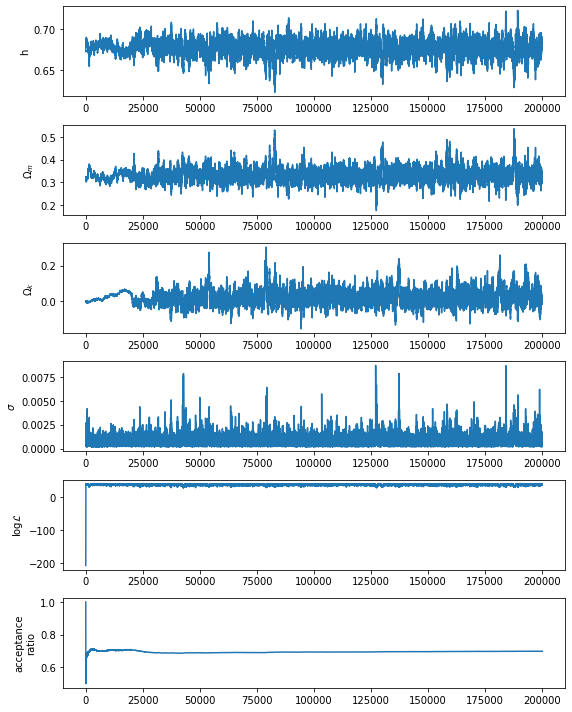

In [30]:
burn = 0
end  = -1
plotChains(M, burn, end)

In [31]:
# autocorrelated function -> determine every N steps to pick one step
def autocorrelate(x,lags):
    n=len(x)
    # pad 0s to 2n-1
    size=2*n-1
    
    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp, size)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]


def auto(chain, nlag, labs):
    nParam = chain.shape[1]
    lags = np.arange(nlag)
    fig, ax = plt.subplots()
    for i in range(nParam):
        result = autocorrelate(chain[:,i],lags)
        print(1+2*np.sum(result))
        ax.plot(result, label=labs[i])
    ax.legend()
    ax.set_xlabel('lag k [steps]')
    ax.set_ylabel('P(k)')
    plt.tight_layout();

366.802945348188
391.76081910890895
465.3827025207589


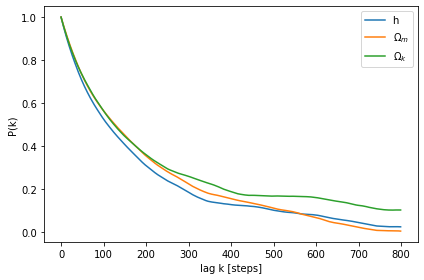

In [32]:
burn = 1000
end = -1
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

auto(M.chain[burn:end,:], nlag=800, labs=labels)

In [33]:
#combine all of chains of walkers: 
#burn is the first N steps which will be discarded
#thin is every how many steps choose one step to avoid co-corelated between adjacent steps
def flat_chain_1walker(chain,burn=100, thin=1500):

    Nsteps = len(chain)
    NParams = len(chain[0])

    use_chain_point_all = []
    use_walker_chain = chain[burn:,:]
    use_len = len(use_walker_chain)
    index = 0
    if thin !=False:
        while index < use_len:
            use_chain_point_all.append(use_walker_chain[index,:])
            index+=thin

        return np.array(use_chain_point_all)
    else:
        return use_walker_chain
        
        

In [34]:
flat_chain_final  = flat_chain_1walker(M.chain,burn=burn, thin=800)
samples = flat_chain_final

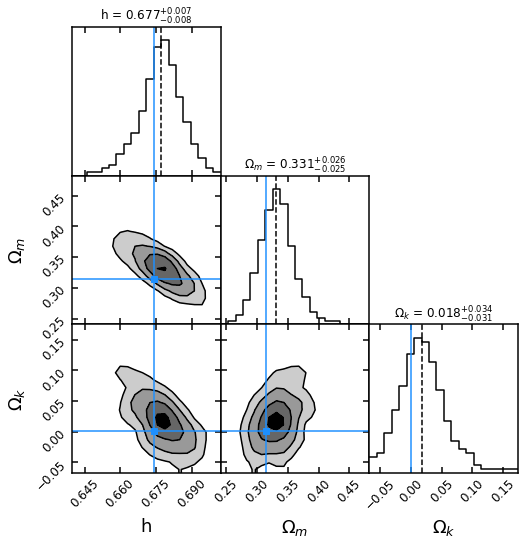

In [35]:
# show corner
labels = ["h", "$\Omega_{m}$", "$\Omega_{k}$"]

fig = corner.corner(\
    samples[:,:],\
    truths=initial_state,\
    truth_color='dodgerblue',\
    labels=labels,\
    label_kwargs={'color':'k', 'fontsize': 18},\
    show_titles=True,\
    title_fmt = '.3f',\
    title_kwargs={'color':'k', 'fontsize': 12},\
    plot_datapoints=False,\
    plot_density=False,\
    plot_contours=True,\
    fill_contours=True,\
    smooth1d=True,\
    smooth=True,\
    reverse=False,\
    quantiles=[0.5])

for axs in fig.get_axes():
        axs.tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=12)
        axs.tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=12)
        for axis in ['top','bottom','left','right']:
            axs.spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


/Users/sunyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.082, 0.5, '${100*r_{D}/d_{M}}$')

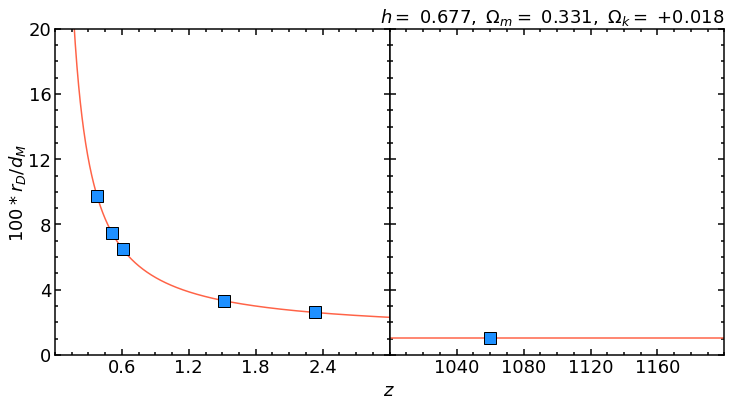

In [36]:
# loops through each value of redshift
z_array_1 = np.linspace(0.0, 3.0, 1001)
z_array_2 = np.linspace(1000.0, 1200.0, 1001)
ratio_array_1 = np.copy(z_array_1)
ratio_array_2 = np.copy(z_array_2)
best_fit_1 = np.median(samples[:, 0])
best_fit_2 = np.median(samples[:, 1])
best_fit_3 = np.median(samples[:, 2])
for i, z in enumerate(z_array_1):
    ratio_array_1[i] = ratio(z, best_fit_1, best_fit_2, best_fit_3)
for i, z in enumerate(z_array_2):
    ratio_array_2[i] = ratio(z, best_fit_1, best_fit_2, best_fit_3)
    
# plotting the distance measurement fit of running emcee
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey='row')

axs[0].tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=18)
axs[0].tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=18)
axs[0].set_xlim(0.0, 3.0)
axs[0].set_ylim(0.0, 20.0)
axs[0].set_xticks((0.6, 1.2, 1.8, 2.4))
axs[0].set_yticks((0.0, 4.0, 8.0, 12.0, 16.0, 20.0))
axs[0].xaxis.set_minor_locator(MultipleLocator(0.15))
axs[0].yaxis.set_minor_locator(MultipleLocator(1.00))

axs[1].tick_params(axis='both', which='major', direction='in', bottom=True, top=True, left=True, right=True, length=6, width=1.5, labelsize=18)
axs[1].tick_params(axis='both', which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=3, width=1.5, labelsize=18)
axs[1].set_xlim(1000.0, 1200.0)
axs[1].set_ylim(0.0, 20.0)
axs[1].set_xticks((1040, 1080, 1120, 1160))
axs[1].set_yticks((0.0, 4.0, 8.0, 12.0, 16.0, 20.0))
axs[1].xaxis.set_minor_locator(MultipleLocator(10.0))
axs[1].yaxis.set_minor_locator(MultipleLocator(1.00))


axs[0].plot(z_array_1, 100*ratio_array_1, color='tomato')
axs[0].plot(data_x, 100*data_y, color='dodgerblue', markeredgecolor='k', marker='s', markersize=12, ls='')
axs[0].errorbar(data_x, 100*data_y, yerr=100*data_z, color='dodgerblue', fmt='none', ls='')

axs[1].plot(z_array_2, 100*ratio_array_2, color='tomato')
axs[1].plot(data_x, 100*data_y, color='dodgerblue', markeredgecolor='k', marker='s', markersize=12, ls='')
axs[1].errorbar(data_x, 100*data_y, yerr=100*data_z, color='dodgerblue', fmt='none', ls='')

l1 = r'${h = \,\,}$' + r'${:5.3f}$'.format(best_fit_1)
l2 = r'${,\ \Omega_{m} = \,\,}$' + r'${:5.3f}$'.format(best_fit_2)
l3 = r'${,\ \Omega_{k} = \,\,}$' + r'${:+5.3f}$'.format(best_fit_3)
string = l1 + l2 + l3
plt.title(string, loc='right', fontsize=18)


for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(1.5)
    axs[1].spines[axis].set_linewidth(1.5)
plt.subplots_adjust(hspace=0.0, wspace=0.0)
fig.text(0.512, 0.042, r'${z}$', fontsize=18, ha='center', va='center')
fig.text(0.082, 0.500, r'${100*r_{D}/d_{M}}$', fontsize=18, ha='center', va='center', rotation=90)